In [1]:
%matplotlib inline

## Example: applying the PathCORE-T software to 10 _k_=24 NMF models of the normalized TCGA dataset.

In [2]:
print(__doc__)

from copy import deepcopy
from functools import partial
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathcore import CoNetwork
from pathcore import aggregate_permuted_network, \
        network_edges_permutation_test
from pathcore import pathway_enrichment_with_overlap_correction
import seaborn as sns
from sklearn.decomposition import NMF, PCA

Automatically created module for IPython interactive environment


This example is run after the TCGA dataset has been downloaded and normalized.
You can download the file from the Zenodo record [here](https://zenodo.org/record/56735) or use the [shell script in the `../data` directory](https://github.com/greenelab/PathCORE-T-analysis/blob/master/data/download_data.sh) (keep in mind this 
script will download more than just the TCGA dataset). 

After downloading the file, use the script [`get_normalized_TCGA_dataset.py`](https://github.com/greenelab/PathCORE-T-analysis/blob/master/data/get_normalized_TCGA_dataset.py)
to get the normalized dataset.

In [3]:
data_dir = os.path.join("..", "data")
tcga_data_dir = os.path.join(data_dir, "tcga_data")

data_file = os.path.join(tcga_data_dir, "HiSeqV2_minmaxscale_normalized")
pathways_file = os.path.join(tcga_data_dir, "PID_pathway_definitions.txt")

Load the normalized dataset

In [4]:
data_df = pd.read_table(data_file, header=0)
index_on = data_df.columns[0]
data_df.set_index(index_on, inplace=True)
data_df = data_df.sort_index()

### Analysis: determining the number of NMF components by examining the principal components of the dataset

Visualize the fraction of total variance in the data explained by each principal component in Principal Components Analysis (PCA) to determine an appropriate number of NMF components. 

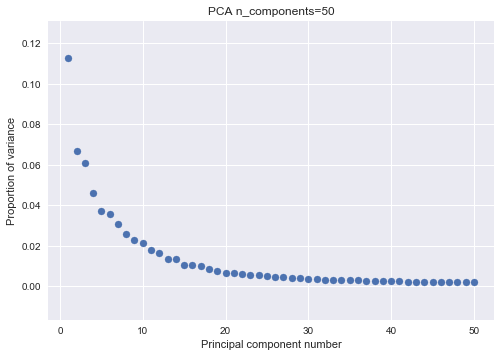

In [5]:
n_components = 50
pca = PCA(n_components=n_components, random_state=42)
pca.fit(data_df.T)
variance_explained = pca.explained_variance_ratio_

plt.scatter(
    list(range(1, len(variance_explained) + 1)),
    variance_explained)
plt.xlabel('Principal component number')
plt.ylabel('Proportion of variance')
plt.title('PCA n_components={0}'.format(n_components))
plt.show()

The proportion of variance explained by each component, explicitly:

In [6]:
variance_explained

array([ 0.11266259,  0.06688258,  0.06086373,  0.0460368 ,  0.03688498,
        0.03573801,  0.0307545 ,  0.02571392,  0.0227316 ,  0.02125907,
        0.01804485,  0.01618074,  0.01360996,  0.01336723,  0.01063505,
        0.01049298,  0.0100946 ,  0.00853679,  0.00747129,  0.0066962 ,
        0.00634571,  0.0061404 ,  0.0056798 ,  0.0055327 ,  0.00497176,
        0.00472375,  0.00457551,  0.00427963,  0.00379434,  0.00369664,
        0.00347115,  0.00325509,  0.00310033,  0.00308135,  0.00295372,
        0.0028504 ,  0.00279685,  0.00268549,  0.00256166,  0.00248202,
        0.00241397,  0.00225573,  0.00222781,  0.00217936,  0.002158  ,
        0.00213512,  0.0019845 ,  0.00192908,  0.00188141,  0.00182891])

We can see that the proportion of variance explained by a PC falls below 0.005 (0.5%) at 24 components. 

In [7]:
sum(variance_explained[:24])

0.59835608102161053

On the other hand, the total proportion of variance explained by 24 PCs is only 0.60. If we look at the proportion of variance explained by _k_=300, the number of components in the TCGA NMF-based example of our manuscript:

In [8]:
n_components = 300
pca = PCA(n_components=n_components, random_state=42)
pca.fit(data_df.T)
print("Percent variance explained by k={0}: {1}".format(
    n_components, sum(pca.explained_variance_ratio_)))

Percent variance explained by k=300: 0.806375026754258


We note that we would need an extremely large number of PCs to explain 90% of the variance in the data.

### PathCORE-T analysis

In this example, we would like to examine the results of PathCORE-T
when we limit the number of NMF components to the number of PCs that
each explain greater than 0.5% of the variance in the data.

Ahead of creating this notebook, we found that the creation of a single
_k_=24 NMF model resulted in 0 significant edges after permutation testing
in PathCORE-T. This is because a given pathway-pathway relationship was
overrepresented in at most 2 of the NMF components based on the NMF
gene signature we specified in the paper (genes with weight 2 standard
deviations above the component's mean weight).

We proceed here with the construction of 10 _k_=24 NMF models (each initialized
with different random seeds). We found that for models with very few components,
PathCORE-T analysis can identify meaningful edges by aggregating the results
from multiple models. This analysis is similar to what we did for the PAO1
eADAGE-based example in the PathCORE-T manuscript.

In [9]:
# initialize constants for the PathCORE-T analysis
n_models = 10
n_features = 24

gene_signature_std = 2.0

n_permutations = 10000
permutation_test_alpha = 0.05

In [10]:
pathway_definitions_df = pd.read_table(
    pathways_file, header=None, names=["pw", "size", "genes"])
pathway_definitions_df["genes"] = pathway_definitions_df["genes"].map(
    lambda x: x.split(";"))
pathway_definitions_df.set_index("pw", inplace=True)

pathway_definitions_map = {}
for index, row in pathway_definitions_df.iterrows():
    pathway_definitions_map[index] = set(row["genes"])

print("Example of a key-value pair in the `pathway_definitions_map` dict:")
print(list(pathway_definitions_map.items())[0])

Example of a key-value pair in the `pathway_definitions_map` dict:
('FANCONI_PATHWAY', {'RAD17', 'FANCD2', 'BRCA1', 'FANCM', 'HUS1', 'BRCA2', 'RFC2', 'FANCB', 'PALB2', 'FAN1', 'FANCE', 'UBE2T', 'FANCL', 'RAD9A', 'APITD1', 'TOP3A', 'RAD1', 'C17orf70', 'RMI1', 'ATM', 'TOPBP1', 'SSPO', 'XRCC3', 'NBN', 'FANCF', 'RFC4', 'FANCC', 'WDR48', 'RFC3', 'USP1', 'RFC5', 'BLM', 'RPA2', 'FANCI', 'C19orf40', 'MRE11A', 'H2AFX', 'HES1', 'FANCA', 'RPA1', 'CHEK1', 'ATR', 'FBXW11', 'ATRIP', 'BRIP1', 'FANCG', 'RAD50'})


In [11]:
%%time
models = []
for rseed in range(n_models):
    model = NMF(n_components=n_features,
          init="nndsvda",
          solver="cd",
          random_state=rseed)
    model.fit_transform(data_df.T)
    models.append(model)

CPU times: user 35min 50s, sys: 21 s, total: 36min 11s
Wall time: 18min 30s


In [12]:
def get_NMF_feature_weights(model):
    gene_weights_across_components = {}
    for index, gene_weights in enumerate(model.components_.T):
        gene = data_df.index[index]
        gene_weights_across_components[gene] = list(gene_weights)
    weights_df = pd.DataFrame.from_dict(gene_weights_across_components,
                                           orient="index")
    return weights_df

model_weights = []
for m in models:
    model_weights.append(get_NMF_feature_weights(m))

In [13]:
def get_pathways_overrepresented_in_features(current_weight_matrix, pathway_definitions,
                                             partial_function_signature,
                                             alpha=0.05, correct_all_genes=True,
                                             metadata=False):
    """
    This method is a simplification of the method already provided in the
    PathCORE-T-analysis repository.
    See documentation:
      https://github.com/greenelab/PathCORE-T-analysis/blob/master/run_network_creation.py#L155
    
    Modifications:
    * Removed the `overlap_correction` parameter for this example
      - overlap correction will be applied by default.
    * `current_weight_matrix` is just a pandas.DataFrame rather
      than a tuple of a filename and a pandas.DataFrame

    We kept some of the parameters (alpha, correct_all_genes, metadata)
    so that users interested in running the notebook themselves
    could examine differences in results that occurs with parameter
    changes and/or view the metadata that accompanies this analysis.
    """
    n_genes, _ = current_weight_matrix.shape
    significant_pathways_df = pd.DataFrame()
    feature_metadata = {}
    for feature in current_weight_matrix:
        feature_df, additional = \
            pathway_enrichment_with_overlap_correction(
                current_weight_matrix[feature], pathway_definitions,
                partial_function_signature,
                alpha=alpha, correct_all_genes=correct_all_genes,
                metadata=metadata)
        if feature_df is not None:
            feature_df.loc[:, "feature"] = pd.Series(
                [feature] * len(feature_df.index), index=feature_df.index)
            significant_pathways_df = pd.concat(
                [significant_pathways_df, feature_df], axis=0)
            if additional:
                feature_metadata[feature] = additional
    significant_pathways_df.reset_index(drop=True, inplace=True)
    return {"significant_pathways": significant_pathways_df,
            "feature_metadata": feature_metadata}

Pathway overrepresentation analysis applied to each component of each model.

In [14]:
%%time
def NMF_gene_signature(feature_weight_vector):
    mean = feature_weight_vector.mean()
    cutoff = gene_signature_std * feature_weight_vector.std()
    positive_gene_signature = set(
        feature_weight_vector[(feature_weight_vector >=
                              mean + cutoff)].index)
    return (positive_gene_signature, set())

model_pathways = []
for weights in model_weights:
    feature_significant_pathways = get_pathways_overrepresented_in_features(
        weights, pathway_definitions_map, NMF_gene_signature)
    model_pathways.append(feature_significant_pathways["significant_pathways"])

79 adjustments made to a vector of length 196 containing the raw weight values in a call to 'update_probabilities'
148 adjustments made to a vector of length 196 containing the raw weight values in a call to 'update_probabilities'
98 adjustments made to a vector of length 196 containing the raw weight values in a call to 'update_probabilities'
62 adjustments made to a vector of length 196 containing the raw weight values in a call to 'update_probabilities'
97 adjustments made to a vector of length 196 containing the raw weight values in a call to 'update_probabilities'
83 adjustments made to a vector of length 196 containing the raw weight values in a call to 'update_probabilities'
148 adjustments made to a vector of length 196 containing the raw weight values in a call to 'update_probabilities'
56 adjustments made to a vector of length 196 containing the raw weight values in a call to 'update_probabilities'
138 adjustments made to a vector of length 196 containing the raw weight value

Network construction

In [15]:
aggregate_network = None
networks = []
for mp in model_pathways:
    model_network = CoNetwork(
        n_features, significant_pathways=mp)
    networks.append(model_network)
    if aggregate_network is None:
        aggregate_network = deepcopy(model_network)
    else:
        aggregate_network.aggregate(model_network)

In [16]:
model_network_df = aggregate_network.to_dataframe()
print("Number of edges in the network: {0}".format(len(model_network_df)))

edges_above_one = model_network_df[model_network_df.weight > 1]
print("Number of edges with a weight above 1 "
      "(i.e. the pathway-pathway relationship appears "
      "in more than one feature): {0}".format(
          len(edges_above_one)))
edges_above_one.head()

The pathway co-occurrence network contains 85 pathways.
Number of edges in the network: 591
Number of edges with a weight above 1 (i.e. the pathway-pathway relationship appears in more than one feature): 457


,pw0,pw1,weight
2,A6B1_A6B4_INTEGRIN_PATHWAY,TAP63_PATHWAY,28
69,IL12_2PATHWAY,TOLL_ENDOGENOUS_PATHWAY,20
245,AVB3_INTEGRIN_PATHWAY,INTEGRIN1_PATHWAY,20
58,FCER1_PATHWAY,IL12_2PATHWAY,19
19,IL12_2PATHWAY,IL4_2PATHWAY,19


Permutation test

In [17]:
%%time
permutations = []
for i in range(10000):
    permutations.append(aggregate_permuted_network(networks))

CPU times: user 13min 23s, sys: 6.91 s, total: 13min 30s
Wall time: 13min 36s


In [18]:
final_network = network_edges_permutation_test(
    aggregate_network, permutations, permutation_test_alpha,
    n_networks=10)

364 edges are significant under the null distribution, generated from 10000 permutations, for alpha = 0.05.


In [19]:
significant_edges = []
for edge_id, edge_obj in final_network.edges.items():
    if edge_obj.significant:
        pw0, pw1 = final_network.get_edge_pathways(edge_id)
        significant_edges.append({"pw0": pw0, "pw1": pw1, "odds ratio": edge_obj.weight})
significant_edges_df = pd.DataFrame(significant_edges)
significant_edges_df.sort_values("odds ratio", ascending=False)
significant_edges_df

,odds ratio,pw0,pw1
0,2.351743,P53_DOWNSTREAM_PATHWAY,TAP63_PATHWAY
1,4.448298,NECTIN_PATHWAY,TAP63_PATHWAY
2,2.868206,A6B1_A6B4_INTEGRIN_PATHWAY,TAP63_PATHWAY
3,2.488682,NFAT_TFPATHWAY,TAP63_PATHWAY
4,4.995847,NECTIN_PATHWAY,P53_DOWNSTREAM_PATHWAY
5,3.144205,NFAT_TFPATHWAY,P53_DOWNSTREAM_PATHWAY
6,2.776606,A6B1_A6B4_INTEGRIN_PATHWAY,NECTIN_PATHWAY
7,5.436900,NECTIN_PATHWAY,NFAT_TFPATHWAY
8,5.312139,CXCR4_PATHWAY,IL4_2PATHWAY
9,2.878846,IL4_2PATHWAY,TCR_PATHWAY


Check which edges the _k_=24 NMF-based TCGA PID network has in common with the _k_=300 NMF-based TCGA PID network 

In [20]:
NMF_k300_edges_file = os.path.join(tcga_data_dir,
                                   "NMF_analysis",
                                   "permutation_test_N=10000",
                                   "significant_edges.tsv")
NMF_k300_edges = {}
with open(NMF_k300_edges_file, 'r') as file_handle:
    file_handle.readline()
    for line in file_handle:
        cols = line.strip().split('\t')
        NMF_k300_edges[(cols[0], cols[1])] = float(cols[-1])
print("Number of edges in the manuscript's k=300 "
      "NMF-based TCGA PID network: {0}".format(
          len(NMF_k300_edges)))

Number of edges in the manuscript's k=300 NMF-based TCGA PID network: 119


In [21]:
# shorten the PID pathway names so that they match the ones
# we use in the publication
def tcga_shorten_pid(pathway_name):
    REMOVE_SUFFIX = "PATHWAY"
    pathway_short = None
    split_on_underscores = pathway_name.split("_")
    if split_on_underscores[-1] == REMOVE_SUFFIX:
        pathway_short = " ".join(split_on_underscores[:-1])
    else:
        pathway_short = " ".join(split_on_underscores)
    return pathway_short

NMF_k24_edges = {}
for edge_id, edge_obj in final_network.edges.items():
    if edge_obj.significant:
        pw0, pw1 = final_network.get_edge_pathways(edge_id)
        pw0 = tcga_shorten_pid(pw0)
        pw1 = tcga_shorten_pid(pw1)
        NMF_k24_edges[(pw0, pw1)] = edge_obj.weight

In [22]:
set_of_k24_edges = set(NMF_k24_edges.keys())
set_of_k300_edges = set(NMF_k300_edges.keys())
common_edges = set_of_k24_edges & set_of_k300_edges
print("Common edges: {0}".format(len(common_edges)))

Common edges: 65


In [23]:
remaining_k300_edges = set_of_k300_edges - set_of_k24_edges

In [24]:
remaining_k24_edges = set_of_k24_edges - set_of_k300_edges

The edges that the two networks share have a higher weight, on average, than the edges that the two networks do not share:

In [25]:
common_k300_edge_weights = [] 
common_k24_edge_weights = []
for e in common_edges:
    common_k300_edge_weights.append(NMF_k300_edges[e])
    common_k24_edge_weights.append(NMF_k24_edges[e])
print("Average weight of edges in the k=300 NMF-based network "
      "common to the k=300 and k=24 NMF-based networks: {0:.3}".format(
           np.average(common_k300_edge_weights)))
print("Average weight of edges in the k=24 NMF-based network "
      "common to the k=300 and k=24 NMF-based networks: {0:.3}".format(
           np.average(common_k24_edge_weights)))

Average weight of edges in the k=300 NMF-based network common to the k=300 and k=24 NMF-based networks: 3.77
Average weight of edges in the k=24 NMF-based network common to the k=300 and k=24 NMF-based networks: 5.38


In [26]:
remaining_k300_edge_weights = [] 
for e in remaining_k300_edges:
    remaining_k300_edge_weights.append(NMF_k300_edges[e])
print("Average weight of edges in the k=300 NMF-based network "
       "not in the k=24 network: {0:.3}".format(
           np.average(remaining_k300_edge_weights)))

Average weight of edges in the k=300 NMF-based network not in the k=24 network: 2.76


In [27]:
remaining_k24_edge_weights = [] 
for e in remaining_k24_edges:
    remaining_k24_edge_weights.append(NMF_k24_edges[e])
print("Average weight of edges in the k=24 NMF-based network "
       "not in the k=300 network: {0:.3}".format(
           np.average(remaining_k24_edge_weights)))

Average weight of edges in the k=24 NMF-based network not in the k=300 network: 3.75
